# Model #3 Multivariate LSTM (Diesel -> Spot Price)
* Import fuel_prices_com.csv & GBP_USD.csv
* Using Fuel Prices and Forex Spot Price as input into an LSTM model to predict Forex Spot Price of the currency pair in question.

# Imports

In [ ]:
# Imports
!pip install git+https://github.com/tensorflow/docs
import tensorflow as tf
print(tf.__version__)

# Libraries
import pathlib
import numpy as np
import pandas as pd
from numpy import array

# Plotting
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
plt.style.use('seaborn')
from matplotlib import rcParams

# Model
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import InputLayer, Dense, LSTM, Dropout
from numpy.random import seed
from random import shuffle

# Metric
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-srq_eo3k
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-srq_eo3k
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0ff623b83a13034bdb4f84fc1299e7a2e23267968_-cp36-none-any.whl size=146353 sha256=cd2d4c095bc42777a4bf8f76a3318b80397ba9467e77d0eb2a2650f8ff1959f7
  Stored in directory: /tmp/pip-ephem-wheel-cache-5dxqpb6x/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs
2.3.0


In [ ]:
seed(1)
tf.random.set_seed(2)

# Data Collection


In [ ]:
# Import forex
forex_dataset_data= pd.read_csv('GBP_USD.csv', na_values = "?", comment='\t', skipinitialspace=True)
forex_dataset = forex_dataset_data.copy()
forex_dataset = forex_dataset.fillna(method='ffill')
forex_dataset = pd.DataFrame(forex_dataset,columns=['Price','Date'])


In [ ]:
# Import price
fuel_dataset = pd.read_csv('fuel_prices_com.csv', encoding= 'unicode_escape')
fuel_dataset = fuel_dataset.loc[fuel_dataset.Country=='USA', ['Date','Diesel']]

# Data Preprocessing / Data Cleaning & Collating
*   We first isolate the date column both fuel_dataset and forex_dataset so that they are formatted in the same way.  
*   Challenge: Fuel Price dataset is a weekly timeseries dataset whereas Forex Price is a daily timeseries dataset.


In [ ]:
fuel_dataset['Date'] = fuel_dataset['Date'].apply(lambda x: pd.to_datetime(str(x)))
fuel_dataset['Date'].head()


772   2020-06-01
773   2020-01-13
774   2020-01-20
775   2020-01-27
776   2020-03-02
Name: Date, dtype: datetime64[ns]

In [ ]:
# We find out the format for where the day, month and year lie.
fuel_dataset["Date"] = pd.to_datetime(fuel_dataset["Date"], format="%d-%m-%Y")
forex_dataset["Date"] = pd.to_datetime(forex_dataset["Date"], format="%b %d, %Y")
# We transform these values to the same format.
fuel_dataset["Date"] = fuel_dataset["Date"].dt.strftime("%d-%m-%Y")
forex_dataset["Date"] = forex_dataset["Date"].dt.strftime("%d-%m-%Y")
# We then convert them back to a dataframe.
fuel_dataset["Date"] = pd.to_datetime(fuel_dataset["Date"], format="%d-%m-%Y")
forex_dataset["Date"] = pd.to_datetime(forex_dataset["Date"], format="%d-%m-%Y")

In [ ]:
# We set the index for both datasets to be date.
forex_dataset.set_index("Date", inplace=True)
fuel_dataset.set_index("Date", inplace=True)
forex_dataset["Date"] = forex_dataset.index
fuel_dataset["date"] = fuel_dataset.index

In [ ]:
# We then group these dates in a weekly period column
fuel_dataset["week"] = fuel_dataset.index.to_period('W')
forex_dataset["week"] = forex_dataset.index.to_period('W')

In [ ]:
# We then join our datasets on the week column
data_ff = pd.merge(
    forex_dataset,
    fuel_dataset,
    left_on="week",
    right_on="week",
    how="left"
)

In [ ]:
data_ff[data_ff.Diesel.isnull() | data_ff.Price.isnull()]

,Price,Date,week,Diesel,date
15,1.2542,2020-06-12,2020-06-08/2020-06-14,NaN,NaT
16,1.2602,2020-06-11,2020-06-08/2020-06-14,NaN,NaT
17,1.2747,2020-06-10,2020-06-08/2020-06-14,NaN,NaT
18,1.2731,2020-06-09,2020-06-08/2020-06-14,NaN,NaT
19,1.2723,2020-06-08,2020-06-08/2020-06-14,NaN,NaT
45,1.2106,2020-05-15,2020-05-11/2020-05-17,NaN,NaT
46,1.2228,2020-05-14,2020-05-11/2020-05-17,NaN,NaT
47,1.2230,2020-05-13,2020-05-11/2020-05-17,NaN,NaT
48,1.2261,2020-05-12,2020-05-11/2020-05-17,NaN,NaT
49,1.2336,2020-05-11,2020-05-11/2020-05-17,NaN,NaT


In [ ]:
# We isolate the features that we want in our dataset
data_ff = pd.DataFrame(data_ff, columns = ['Date', 'Price', 'Diesel']) 
data_ff['Diesel'].fillna((data_ff['Diesel'].mean()), inplace=True) # Notice how our dataset starts from the end rather than the top
dataset = data_ff.iloc[::-1,:] # Reverse order of dataset
dataset.reset_index(drop=True, inplace=True) #Reset index

In [ ]:
dataset = pd.DataFrame(dataset, columns = ['Date', 'Price', 'Diesel']) 
dataset

,Date,Price,Diesel
0,2019-12-02,1.2937,0.699826
1,2019-12-03,1.2994,0.699826
2,2019-12-04,1.3104,0.699826
3,2019-12-05,1.3157,0.699826
4,2019-12-06,1.3137,0.699826
...,...,...,...
165,2020-06-29,1.2299,0.644000
166,2020-06-30,1.2401,0.644000
167,2020-07-01,1.2474,0.644000
168,2020-07-02,1.2467,0.644000


# Plotting Features before Normalisation

### Organising date for plotting

In [ ]:
# Isolate date for plotting
date = dataset['Date']
# Isolate dates in question
dateFormatting = pd.DataFrame({'new_date': pd.date_range('2019-12-31', '2020-07-31', periods=len(date))})
# Convert date to list so that we can use the dates to plot on graph
my_xticks = dateFormatting['new_date'].tolist()

### Plotting Forex Spot Price

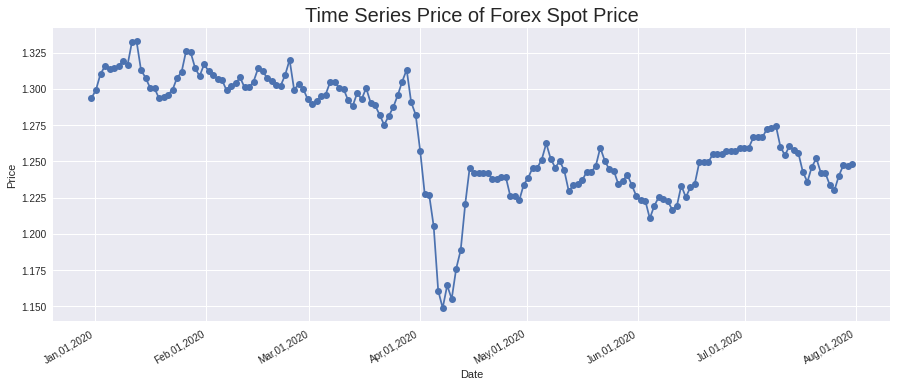

In [ ]:
rcParams['figure.figsize'] = 15,6
dates = np.array(dateFormatting['new_date'])
price = np.array(dataset['Price'])
plt.plot_date(dates,price, linestyle ='solid')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b,%d,%Y')
plt.title('Time Series Price of Forex Spot Price', size = 20)
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(date_format)

### Plotting Diesel Prices

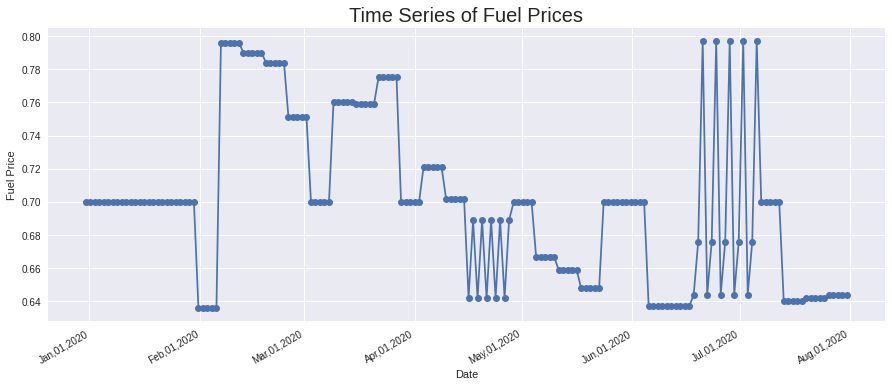

In [ ]:
rcParams['figure.figsize'] = 15,6
dates = np.array(dateFormatting['new_date'])
fuel = np.array(dataset['Diesel'])
plt.plot_date(dates,fuel, linestyle ='solid')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b,%d,%Y')
plt.title('Time Series of Fuel Prices', size = 20)
plt.xlabel('Date')
plt.ylabel('Fuel Price')
plt.gca().xaxis.set_major_formatter(date_format)

# Plotting Features after Normalisation

In [ ]:
price_frame = pd.DataFrame(np.concatenate([price]), columns= ["Price"])
fuel_frame = pd.DataFrame(np.concatenate([fuel]), columns= ["Fuel Price"])


In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
normalisation_price = scaler.fit_transform(price_frame).reshape(-1,1)
normalisation_fuel_price = scaler.fit_transform(fuel_frame).reshape(-1,1)

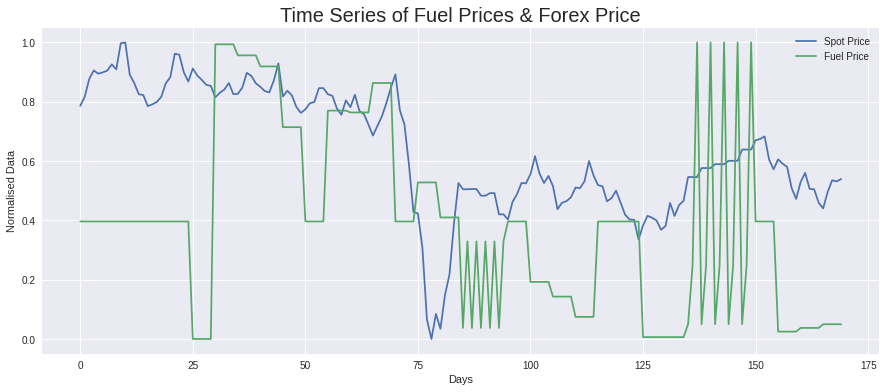

In [ ]:
rcParams['figure.figsize'] = 15,6
plt.plot(normalisation_price, label="Spot Price")
plt.plot(normalisation_fuel_price, label="Fuel Price")
dates = np.array(dateFormatting['new_date'])
plt.title('Time Series of Fuel Prices & Forex Price', size = 20)
plt.ylabel('Normalised Data')
plt.xlabel('Days')
plt.legend() 
plt.show()


# Splitting Data into Train, Validation & Test


In [ ]:
new_dataset = np.hstack((normalisation_fuel_price, normalisation_price))

In [ ]:
# Test, Validation, Train 
training_size = int(len(new_dataset)*0.80)
test_size = (len(new_dataset)-training_size)//2 # // Rounds down
train_data, valset_data, test_data = new_dataset[0:training_size], new_dataset[training_size:(training_size + test_size)],new_dataset[(training_size + test_size):]
print(train_data.shape)
print(valset_data.shape)
print(test_data.shape)

(136, 2)
(17, 2)
(17, 2)


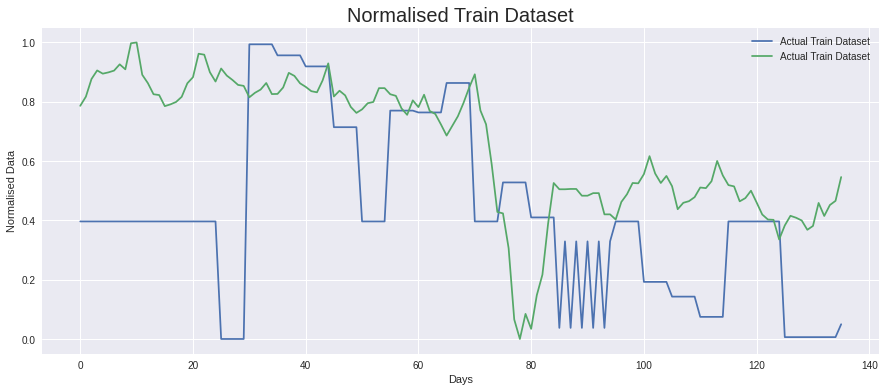

In [ ]:
# Start – Train
rcParams['figure.figsize'] = 15,6
plt.plot(train_data, label="Actual Train Dataset")
plt.title('Normalised Train Dataset', size = 20)
plt.ylabel('Normalised Data')
plt.xlabel('Days')
plt.legend()
plt.show()

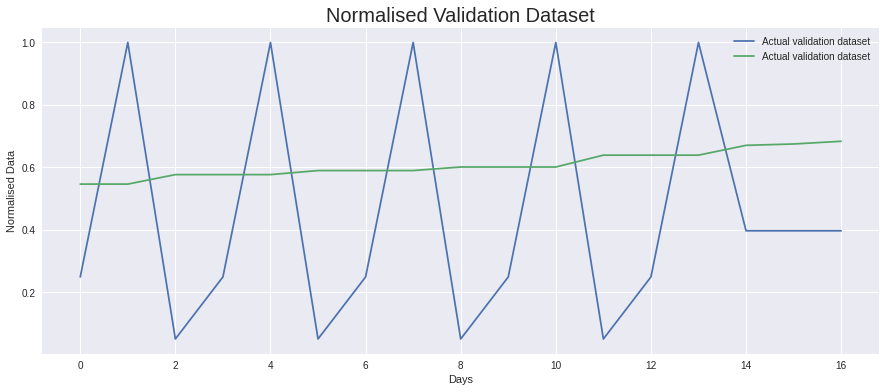

In [ ]:
# Middle – Validation
rcParams['figure.figsize'] = 15,6
plt.plot(valset_data, label="Actual validation dataset")
plt.title('Normalised Validation Dataset', size = 20)
plt.ylabel('Normalised Data')
plt.xlabel('Days')
plt.legend()
plt.show()

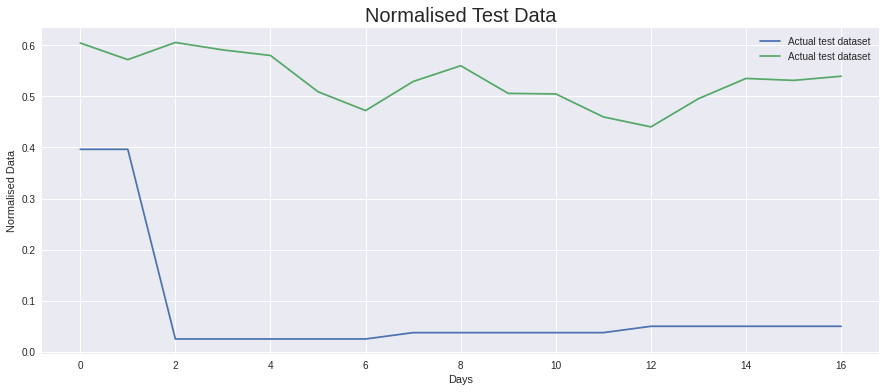

In [ ]:
# End - Test
rcParams['figure.figsize'] = 15,6
plt.plot(test_data, label="Actual test dataset")
plt.title('Normalised Test Data', size =20)
plt.ylabel('Normalised Data')
plt.xlabel('Days')
plt.legend()
plt.show()

# X_train, Y_train, X_test, Y_test

In [ ]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, time_step):
  dataX, dataY = [],[]
  # range: is the days in dataset - the days we need to consider - the 8th day
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step)]  # from i -> 6th day
    dataX.append(a) 
    y = dataset[i + time_step][1] # 7th day
    dataY.append(y)
  return np.array(dataX), np.array(dataY)


In [ ]:
# Weekly_timestep means taking in 7 days of features at a time 
weekly_timestep = 7
X_train, Y_train = create_dataset(train_data, weekly_timestep)
X_val, Y_val = create_dataset(valset_data, weekly_timestep)
X_test, Y_test = create_dataset(test_data, weekly_timestep)



## Data Augmentation

In [ ]:
reversed_x_train = X_train[::-1]
reversed_y_train = Y_train[::-1]
reversed_x_val = X_val[::-1]
reversed_y_val = Y_val[::-1]

new_X_train = np.concatenate((X_train, reversed_x_train))
new_Y_train = np.concatenate((Y_train, reversed_y_train))
new_X_val = np.concatenate((X_val, reversed_x_val))
new_Y_val = np.concatenate((Y_val, reversed_y_val))
print(len(new_X_train))
print(len(new_Y_train))
print(len(new_X_val)) 
print(len(new_Y_val))

256
256
18
18


# Stacked LSTM Model

In [ ]:
def lstm_model(lr_rate, neuron_layer, optimizer_one):
  model = Sequential()
  opt = None
  if optimizer_one == 'adam':
   opt = keras.optimizers.Adam(learning_rate=lr_rate)
  elif optimizer_one == 'sgd':
   opt = keras.optimizers.SGD(learning_rate=lr_rate)
  else:
   opt = keras.optimizers.Adamax(learning_rate=lr_rate)
  model.add(InputLayer(input_shape=(7,2)))
  model.add(LSTM(neuron_layer, return_sequences=True))
  model.add(Dense(10))
  model.add(LSTM(neuron_layer))
  model.add(Dense(1))
  model.compile(loss = 'mean_squared_error', optimizer=opt)
  return model
  

## Hyperparameter Tuning
![Grid Search & Random Search](https://miro.medium.com/max/1200/1*ZTlQm_WRcrNqL-nLnx6GJA.png)



In [ ]:
# Function to create the best model for hyperparameters method
def bestModel(least_loss, learning_rate_list, optimizer_list, neuron_list):
  for each_neuron in neuron_list:
    for each_optimizer in optimizer_list:
      for each_learning_rate in learning_rate_list:
        our_model = lstm_model(each_learning_rate, each_neuron, each_optimizer)
        our_model.fit(new_X_train, new_Y_train, 
                validation_data= 
                (new_X_val, new_Y_val)
                , epochs=100,batch_size=10,verbose=1,
                callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)])
        loss = our_model.evaluate(X_test, Y_test)
        if loss < least_loss:
          least_loss = loss
          best_learning_rate = each_learning_rate
          best_optimizer = each_optimizer
          best_neuron = each_neuron
    return least_loss, best_learning_rate, best_optimizer, best_neuron

### Grid Search





In [ ]:
neuron_list = [15,30,10]
optimizer_list = ['adam', 'adamax']
learning_rate_list = [3e-3,3e-4]
least_loss_grid_search = 1

best_grid_search_model = bestModel(least_loss_grid_search, learning_rate_list, optimizer_list, neuron_list)
print(best_grid_search_model)


Epoch 1/100
26/26 [==============================] - 1s 26ms/step - loss: 0.1035 - val_loss: 0.0034
Epoch 2/100
26/26 [==============================] - 0s 5ms/step - loss: 0.0206 - val_loss: 4.6170e-04
Epoch 3/100
26/26 [==============================] - 0s 5ms/step - loss: 0.0172 - val_loss: 0.0015
Epoch 4/100
26/26 [==============================] - 0s 5ms/step - loss: 0.0145 - val_loss: 0.0048
Epoch 5/100
1/1 [==============================] - 0s 922us/step - loss: 0.0012
Epoch 1/100
26/26 [==============================] - 1s 27ms/step - loss: 0.1866 - val_loss: 0.0810
Epoch 2/100
26/26 [==============================] - 0s 5ms/step - loss: 0.0653 - val_loss: 0.0068
Epoch 3/100
26/26 [==============================] - 0s 5ms/step - loss: 0.0248 - val_loss: 0.0011
Epoch 4/100
26/26 [==============================] - 0s 5ms/step - loss: 0.0243 - val_loss: 6.4784e-04
Epoch 5/100
26/26 [==============================] - 0s 5ms/step - loss: 0.0235 - val_loss: 5.9738e-04
Epoch 6/100
26/

### Random Search




In [ ]:
# Shuffling neuron layers

neuron_list = [15,30,10]
# Seed random number generator
seed(len(neuron_list))
# Prepare a sequence
neuron_sequence = neuron_list
print(neuron_sequence) # Before Shuffle
# Randomly shuffle the sequence hidden layers
shuffle(neuron_sequence) 
print(neuron_sequence) # After Shuffle

[15, 30, 10]
[10, 15, 30]


In [ ]:
# Shuffling optimizers

optimizer_list = ['adam', 'adamax']
# Seed random number generator
seed(len(neuron_sequence))
# Prepare a sequence
op_sequence = optimizer_list
print(op_sequence) # Before Shuffle
# Randomly shuffle the sequence
shuffle(op_sequence)
print(op_sequence) # After Shuffle

['adam', 'adamax']
['adamax', 'adam']


In [ ]:
# Shuffling learning rate

learning_rate_list = [3e-3,3e-4]
# Seed random number generator
seed(len(neuron_sequence))
# Prepare a sequence
lr_sequence = learning_rate_list
print(lr_sequence) # Before Shuffle
# Randomly shuffle the sequence
shuffle(lr_sequence)
print(lr_sequence) # After Shuffle

[0.003, 0.0003]
[0.0003, 0.003]


In [ ]:
# Assigning least_loss
least_loss_random_search = 1


In [ ]:
best_random_grid_model = bestModel(least_loss_random_search, lr_sequence, op_sequence, neuron_sequence)
print(best_random_grid_model)

Epoch 1/100
26/26 [==============================] - 1s 26ms/step - loss: 0.3021 - val_loss: 0.2104
Epoch 2/100
26/26 [==============================] - 0s 5ms/step - loss: 0.2243 - val_loss: 0.1430
Epoch 3/100
26/26 [==============================] - 0s 5ms/step - loss: 0.1544 - val_loss: 0.0837
Epoch 4/100
26/26 [==============================] - 0s 5ms/step - loss: 0.0971 - val_loss: 0.0382
Epoch 5/100
26/26 [==============================] - 0s 6ms/step - loss: 0.0576 - val_loss: 0.0122
Epoch 6/100
26/26 [==============================] - 0s 5ms/step - loss: 0.0366 - val_loss: 0.0027
Epoch 7/100
26/26 [==============================] - 0s 5ms/step - loss: 0.0297 - val_loss: 7.5627e-04
Epoch 8/100
26/26 [==============================] - 0s 5ms/step - loss: 0.0278 - val_loss: 7.5788e-04
Epoch 9/100
26/26 [==============================] - 0s 5ms/step - loss: 0.0274 - val_loss: 7.7555e-04
Epoch 10/100
1/1 [==============================] - 0s 942us/step - loss: 0.0023
Epoch 1/100
26/

#### Deciding on best hyperparameter results

In [ ]:
# We want the smallest loss
# 0 = least loss, 1 = learning rate, 2 = optimizer, 3 = neurons
if best_grid_search_model[0] > best_random_grid_model[0]:
  best_learning_rate = best_random_grid_model[1]
  best_optimizer = best_random_grid_model[2]
  best_neuron = best_random_grid_model[3]
else:
  best_learning_rate = best_grid_search_model[1]
  best_optimizer = best_grid_search_model[2]
  best_neuron = best_grid_search_model[3]
print(best_learning_rate)
print(best_optimizer)
print(best_neuron)

0.003
adam
15


# Best Model Prediction

In [ ]:
best_param_model = lstm_model(best_learning_rate, best_neuron, best_optimizer)
best_param_model.fit(X_train, Y_train, epochs=150,batch_size=10,verbose=1)
loss = best_param_model.evaluate(X_test, Y_test) 

Epoch 1/150
13/13 [==============================] - 0s 5ms/step - loss: 0.2347
Epoch 2/150
13/13 [==============================] - 0s 4ms/step - loss: 0.0451
Epoch 3/150
13/13 [==============================] - 0s 5ms/step - loss: 0.0302
Epoch 4/150
13/13 [==============================] - 0s 4ms/step - loss: 0.0260
Epoch 5/150
13/13 [==============================] - 0s 5ms/step - loss: 0.0214
Epoch 6/150
13/13 [==============================] - 0s 4ms/step - loss: 0.0200
Epoch 7/150
13/13 [==============================] - 0s 4ms/step - loss: 0.0177
Epoch 8/150
13/13 [==============================] - 0s 5ms/step - loss: 0.0159
Epoch 9/150
13/13 [==============================] - 0s 4ms/step - loss: 0.0160
Epoch 10/150
13/13 [==============================] - 0s 4ms/step - loss: 0.0152
Epoch 11/150
13/13 [==============================] - 0s 5ms/step - loss: 0.0155
Epoch 12/150
13/13 [==============================] - 0s 4ms/step - loss: 0.0150
Epoch 13/150
13/13 [=================

# Using best model to predict on X_train & X_test

In [ ]:
# Prediction and check performance metric
train_predict = best_param_model.predict(X_train)
test_predict = best_param_model.predict(X_test)
print(train_predict.shape)
print(test_predict.shape)

(128, 1)
(9, 1)


# Performance Metric




In [ ]:
def get_performance_train (model_pred):
  print('Mean Absolute Error:', mean_absolute_error(Y_train, model_pred).round(4))  
  print('Mean Squared Error:', mean_squared_error(Y_train, model_pred).round(4))
  print('R2_Score:',r2_score(Y_train, model_pred).round(4))

In [ ]:
def get_performance_test (model_pred):
  print('Mean Absolute Error:', mean_absolute_error(Y_test, model_pred).round(4))  
  print('Mean Squared Error:', mean_squared_error(Y_test, model_pred).round(4))  
  print('R2_Score:',r2_score(Y_test, model_pred).round(4))

In [ ]:
print('Train:')
get_performance_train(train_predict)
print('\nTest:')
get_performance_test(test_predict)

Train:
Mean Absolute Error: 0.0334
Mean Squared Error: 0.0019
R2_Score: 0.9625

Test:
Mean Absolute Error: 0.0415
Mean Squared Error: 0.002
R2_Score: -0.5357


# Plotting Train Prediction, Validation & Test Prediction Versus Actual Data

In [ ]:
# Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict =scaler.inverse_transform(test_predict)


### Train Predicted

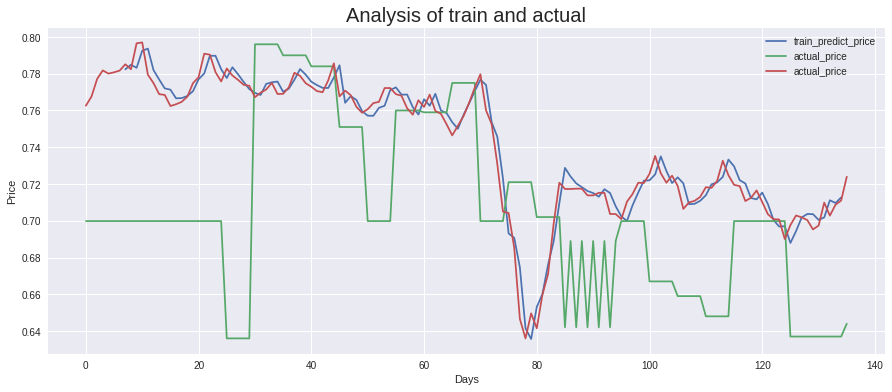

In [ ]:
look_back = 7

trainPredictPlot = np.empty_like(new_dataset) # shape
trainPredictPlot[:,:]= np.nan # values 0
trainPredictPlot[look_back:len(train_predict)+look_back] = train_predict # Populates: 7 -> 162 + 7 = 169

trainPredictPlot = [item[1] for item in trainPredictPlot] 
plt.plot(trainPredictPlot, label="train_predict_price")

train_panda = pd.DataFrame(train_data)
plt.plot(scaler.inverse_transform(train_panda), label="actual_price")

rcParams['figure.figsize'] = 15,6
plt.title('Analysis of train and actual', size = 20)
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend()
plt.show()

## Using last 7 days of training data to predict validation data. 



In [ ]:
temp_input = train_data[-7:] 


In [ ]:
# Demonstrate prediction for the next e.g.4 days:

# Step 1. 7 days of feature = temp_input taken from the last 7 days of the training set
# Step 2  i is the day you are on and we want to predict 4 days: 0,1,2,3 (4 days)
# Step 3. Predict the 8th day on each of the 7 days,
# Step 4. Add this new predicted day to the list
# Step 5. Because we are now taking in the last 7 days + the new predicted value, the list is now size 8  
# Step 6. In order to take in 7 days at a time, we shift 1 to the right.
# Step 7. We reassign the X_train to the new 7 days
# Step 8. We predict the 8th day of the 7 days and continue the process
# Step 9. We then add the 8th day to the output list
# Step 10. We keep track of the 4 days by incrementing by i at the end-> i = i+1
# Step 11. Once we have predicted the 4 days, we return the list of 4 day values.


custom_day = len(valset_data)
lst_output=[]
n_steps=7
i=0
X_input = temp_input
while(i<custom_day):
  if(len(temp_input)>7):
    X_input=array(temp_input[1:])
    X_input=X_input.reshape((1,n_steps,2))
    Y_hat = best_param_model.predict(X_input)
    temp_input = np.append(temp_input, Y_hat)
    temp_input=temp_input[1:]
    lst_output.append(Y_hat[0][0])
    i=i+1
  else:
    X_input=X_input.reshape((1,n_steps,2))
    Y_hat = best_param_model.predict(X_input, verbose=0)
    temp_input = np.append(temp_input, Y_hat)
    lst_output.append(Y_hat[0][0])
    i=i+1
print(lst_output)

[0.54792124, 0.55930257, 0.56404495, 0.65557504, 0.66189265, 0.7343037, 0.7615673, 0.81934696, 0.8545824, 0.8999212, 0.9228037, 0.9424761, 0.9398653, 0.9308903, 0.9103026, 0.89024395, 0.86698395]


## Plotting evaluation: Training Prediction of Validation Dataset

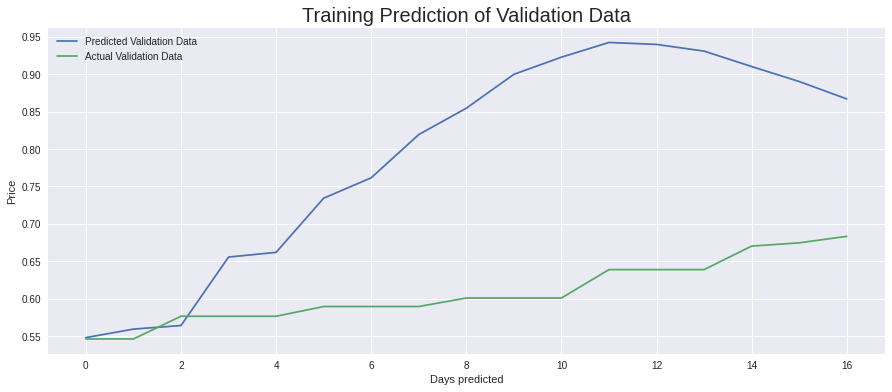

In [ ]:
day_new = custom_day-1

# Predicted days from training
# Transform back to original value before normalised
custom_day_prediction = np.array(lst_output)
# print("Predicted validation:")
# print(custom_day_prediction)
plt.plot(custom_day_prediction, label="Predicted Validation Data")

# Transform back to original value before normalised
val_data = [item[1] for item in valset_data] 
custom_day_validation = val_data[:custom_day]
# print("Actual validation:")
# print(custom_day_validation)
plt.plot(custom_day_validation, label="Actual Validation Data")

# Information
rcParams['figure.figsize'] = 15,6
plt.title('Training Prediction of Validation Data', size = 20)
plt.xlabel('Days predicted')
plt.ylabel('Price')
plt.legend()
plt.show()


## Test Plot

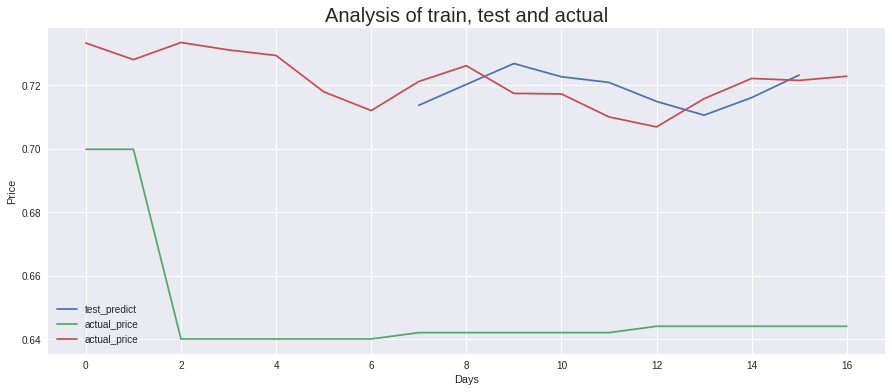

In [ ]:
look_back = 7

testPredictPlot = np.empty_like(new_dataset)
testPredictPlot[:,:]= np.nan
testPredictPlot[look_back:len(test_predict)+look_back] = test_predict
testPredictPlot = [item[1] for item in testPredictPlot] 
plt.plot(testPredictPlot, label="test_predict")

test_panda = pd.DataFrame(test_data)
plt.plot(scaler.inverse_transform(test_panda), label="actual_price")

rcParams['figure.figsize'] = 15,6
plt.title('Analysis of train, test and actual', size = 20)
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend()
plt.show()